Артем Жук, 399 группа
### EM for PCA

В данном репозитории реализованы две вариации ЕМ-алогоритма для анализа главных компонент. Статья с описанием выкладок: http://www.machinelearning.ru/wiki/images/7/73/BMMO11_11.pdf
Интерфейсы классов следуют интерфейсу sklearn.decomposition.PCA.

#### EMPCA
Класс EMPCA является реализацией ЕМ алгоритма для нахожения подпространста пространства признаков, порожденного первыми несколькими главными компонентами. Для всей выборки все признаки должны быть известны.  
Эта реализация опирается на достаточно простые выкладки, а кроме того быстрее работает, чем более общая реализация EMPCAM.

In [1]:
from empca import EMPCA
from empca_missing import EMPCAM
from sklearn.decomposition import PCA
import numpy as np
from utils import random_model, gram_schmidt, span_in, add_missing
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
%matplotlib inline

Сгенерируем выборку. Метод random_model(N, D, d) генрирует выборку с распределением $W\mathcal{N}(0, I_d) + \mathcal{N}(0, \varepsilon I_D), W\in M(\mathbb{R})^{D\times d}$.  
gram_schmidt(X) применяет алгоритм Грама-Шмидта к строкам Х.

In [2]:
X, W, T = random_model(30, 6, 1)
print("W=\n", W)
print("X..=\n", X[:5])

W=
 [[-6.03668996 -2.50185914  5.87075841 -1.91630181  0.02285151 -1.30010382]]
X..=
 [[-2.11248158 -1.29130055  3.36373188 -1.76446742  0.29134367 -1.1935314 ]
 [-3.01631486 -0.36766273  1.97731273 -1.4943377  -0.26496086 -1.00929064]
 [ 3.2746001   1.6476044  -2.25382208  0.54045556 -0.53684432  0.57026261]
 [ 1.16536309 -0.42994578 -0.8617217   0.10735233 -0.50552854 -0.28195391]
 [-8.48255204 -4.64007428  7.49195169 -2.24748483 -0.05914401 -2.01614346]]


Создадим экземпляр EMPCA и запустим на нашей выборке. Поле components_ содержит ортнормированный базис из n_components главных векторов.

In [3]:
empca = EMPCA(n_components=1, n_iter=100)
empca.fit(X)
print('basis:\n', empca.components_)
print('original basis:\n', gram_schmidt(W))

basis:
 [[-0.67155505 -0.28735654  0.63966278 -0.20459612 -0.00150458 -0.1241359 ]]
original basis:
 [[-0.66449795 -0.275396    0.64623278 -0.21093988  0.00251542 -0.14311093]]


Как видим, алгоритм довольно точно определил направляющий вектор прямой, на которой лежат точки. Попробуем для плоскости:

In [4]:
X, W, T = random_model(60, 7, 5)
empca = EMPCA(n_components=1, n_iter=100)
empca.fit(X)
print('basis:\n', empca.components_)
print('original basis:\n', gram_schmidt(W))

basis:
 [[-0.47412271  0.53439374 -0.00968435  0.24609118  0.01713309  0.13625547
   0.64040396]]
original basis:
 [[-0.20980063  0.59305524 -0.53146873  0.39207027  0.01289452  0.12986264
   0.38866502]
 [ 0.15073587 -0.41294762  0.00861573  0.05262656  0.57485332  0.4835377
   0.4895346 ]
 [-0.81506914 -0.18638537  0.40894343  0.28264284  0.03414289 -0.15498573
   0.16915901]
 [ 0.09381917  0.39057734  0.48864196 -0.45663508 -0.24797288  0.06204177
   0.5709825 ]
 [ 0.08170883 -0.52703634 -0.34880968  0.02552453 -0.54651577 -0.28807663
   0.45996635]]


На этот раз сложнее проверить совпадение векторов. Однако для проверки корректности нам можно проверять не точное совпадение базисов, а совпадение подпростраств, на них натянутых. Для этого воспользуемся функцией span_in(A, B), проверяющей что строки А лежат в линейной оболочке строк B.

In [5]:
print('span_in: ', span_in(empca.components_, gram_schmidt(W)))

span_in:  True


Сравним работу нашего преобразователя со стандартным sklearn.decomposition.PCA. Для этого сравним explained_variance_ratio_. Это доля дисперсии, приходящаяся на компоненту.

In [6]:
X, W, T = random_model(100, 500, 100)
pca = PCA(n_components=5)
empca = EMPCA(n_components=5, n_iter=100)

pca.fit(X)
empca.fit(X)

print('pca ratio:\n', pca.explained_variance_ratio_)
print('empca ratio:\n', empca.explained_variance_ratio_)

pca ratio:
 [ 0.04326309  0.04066919  0.03881188  0.03686752  0.03399258]
empca ratio:
 [ 0.04326309  0.04066888  0.03881212  0.03686759  0.03398146]


Как видим, за 100 итераций численный алгоритм достаточно точно нашел пять главных векторов в 500 мерном пространстве. 

##### Демонстрация работы в двумерном случае
Посмотрим на работу нашего алгоритма в двумерном случае. Синие точки -- исходная данная с шумом, красные -- восстановленная зависимость по одной компотненте.

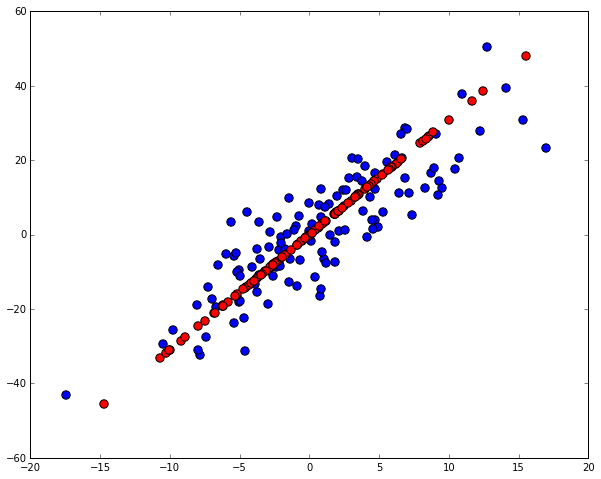

In [7]:
W = np.array([[5, 15]]).T 
X, W, T = random_model(120, 2, 1, W=W, eps=10) 
Xt = deepcopy(X) # original data

empca = EMPCA(n_components=1, n_iter=100)
Xf = empca.fit_transform(X).dot(empca.components_)

plt.figure(figsize=(10, 8))
plt.scatter(Xt[:, 0], Xt[:, 1], c='b', cmap='summer', s=70)
plt.scatter(Xf[:, 0], Xf[:, 1], c='r', cmap='summer', s=70)
plt.show()


##### Зависимость от числа итераций
Теперь посмотрим, как меняется картина с числом итераций. 

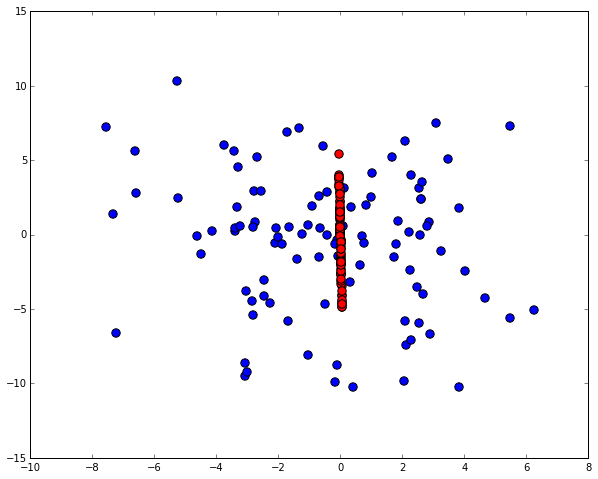

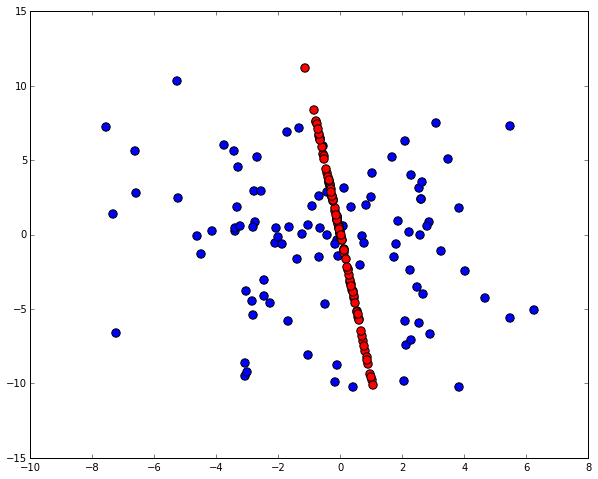

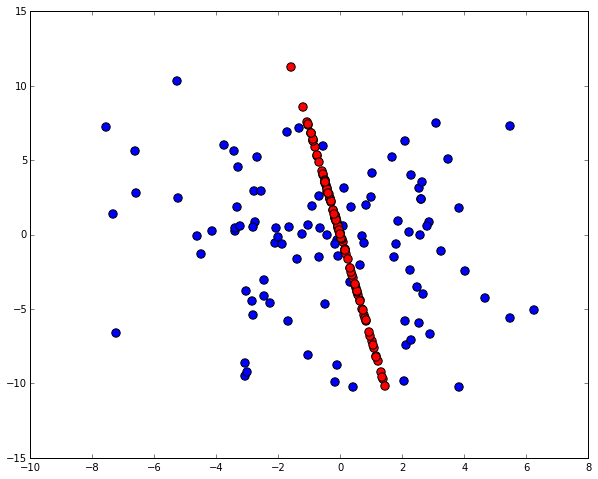

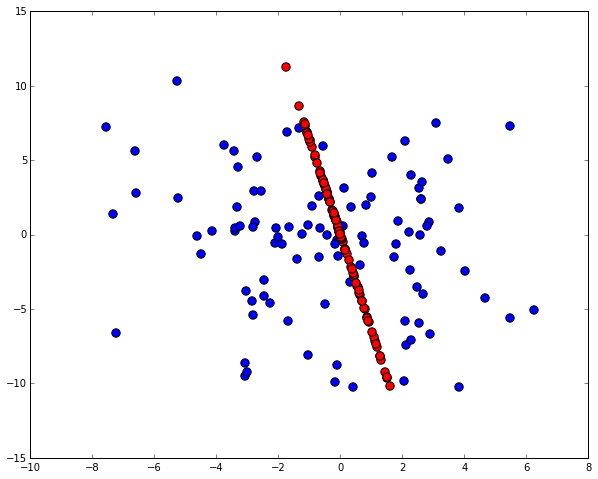

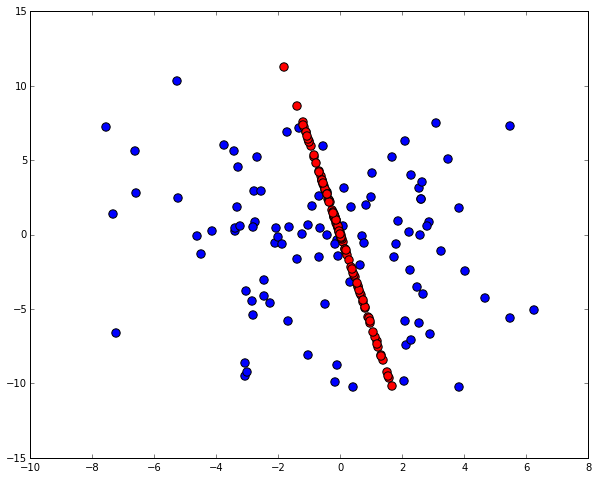

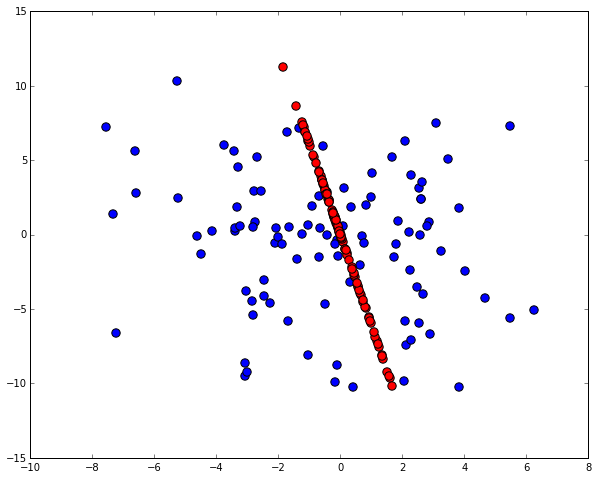

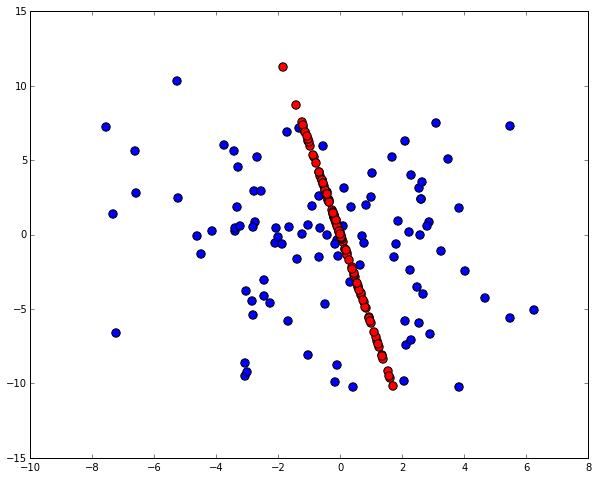

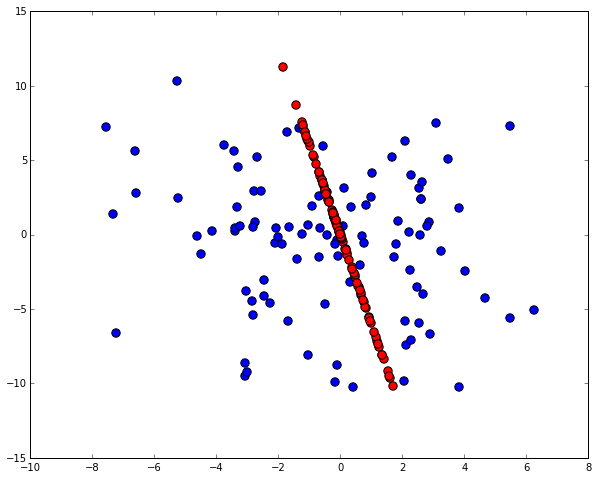

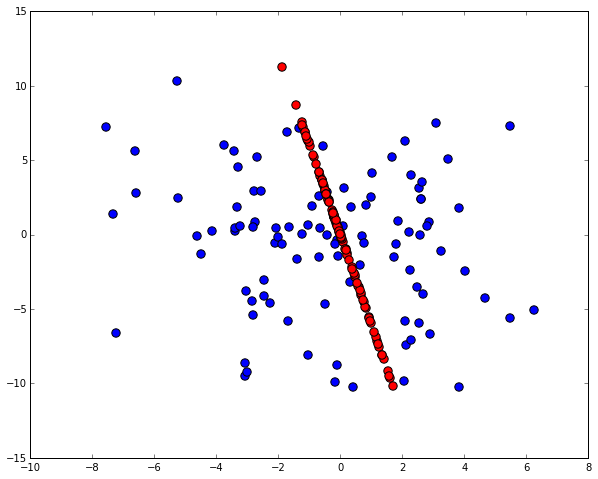

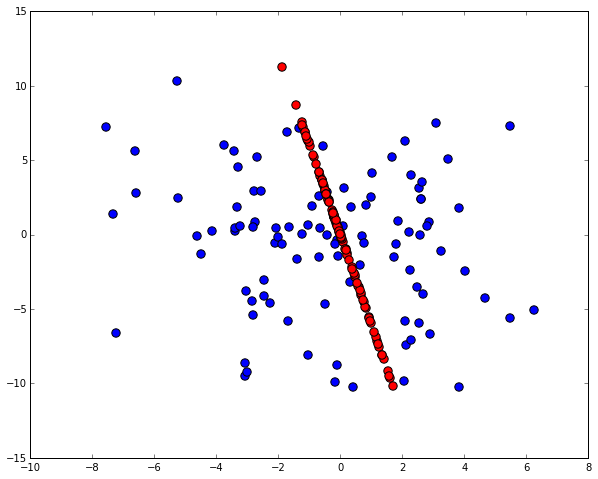

In [27]:
W = np.array([[-1, 3]]).T 
X, W, T = random_model(100, 2, 1, W=W, eps=10) 
empca = EMPCA(n_components=1)
empca.init_(X)

Xt = deepcopy(X) # original data

for k in range(10):
    Xf = empca.transform(X).dot(empca.components_)
    plt.figure(figsize=(10, 8))
    plt.scatter(Xt[:, 0], Xt[:, 1], c='b', cmap='summer', s=70)
    plt.scatter(Xf[:, 0], Xf[:, 1], c='r', cmap='summer', s=70)
    plt.show()
    
    for _ in range(1):
        empca.make_iteration_()
    

Как видим, сходится довольно быстро.

#### EMPCAM
Этот класс реализует тот же алгоритм, но допускает пропуски в данных. 


Сгененрируем выборку с 20% пропущенных значений:

In [9]:
X, W, T = random_model(100, 10, 1)
add_missing(X)
print("X=\n", X[:5])

X=
 [[ -7.51160729   2.79064818  -2.79594077   0.59250319  -2.31967569
    2.7586251    1.72340572  -1.93890777  -4.22904414   7.72977605]
 [  5.79354192  -2.64184904   3.00135058  -0.70371775   3.41153242
   -0.35194282  -0.70300136   3.00908919   4.19628074  -5.97284353]
 [-11.51560873   5.44942671  -3.31990154   3.01230526  -5.52849309
    0.98622763   1.75518149  -4.00010826  -8.17518358  13.4407866 ]
 [ -5.0805403    1.21666771  -1.9011067    1.16047008  -2.70676515
    0.5928792    1.66669572  -0.34502201  -3.0705521    5.53672144]
 [  8.44383773  -3.8493657    2.54555252  -0.73667309   4.27437308
   -1.80272571  -0.1368518    1.4772062    3.89628885  -7.11930845]]


И применим к ней алгоритм: 

In [10]:
empcam = EMPCAM(n_components=1, n_iter=100)
empcam.fit(X)
A = empcam.components_
B = gram_schmidt(W)
print('found basis: ', A)
print('original basis: ', B)
d = A[0] - B[0]
print('A - B: ', d)
print('diff = ', np.linalg.norm(d))

found basis:  [[ 0.56977442 -0.24887493  0.18277562 -0.06659782  0.23853858 -0.07669658
  -0.08832447  0.1475919   0.3531473  -0.59874499]]
original basis:  [[ 0.56727162 -0.25223819  0.1849541  -0.06818136  0.2451631  -0.07651082
  -0.08303563  0.1444721   0.35512605 -0.59655814]]
A - B:  [ 0.00250279  0.00336326 -0.00217847  0.00158353 -0.00662452 -0.00018576
 -0.00528884  0.00311981 -0.00197876 -0.00218685]
diff =  0.0107308133589


Как видим, нам удалось довольно точно восстановить исходную зависимость. 

Теперь построим модель с большим числом латентных переменных и проверим, что найденное подпрастранство попадает в пространство, натянутое на образы латентных переменных.

In [11]:
X, W, T = random_model(100, 30, 5)
add_missing(X, 0.1)
empcam = EMPCAM(n_components=2, n_iter=200)
empcam.fit(X)
print('lies_inside: ', span_in(empcam.components_, gram_schmidt(W)))

lies_inside:  True


Теперь применим это для восстановления компонент. Сгенерируем выборку, а потом удалим 20% точек. 
Синие точки -- исходная выборка с шумом, красные -- восстановленная зависимость.

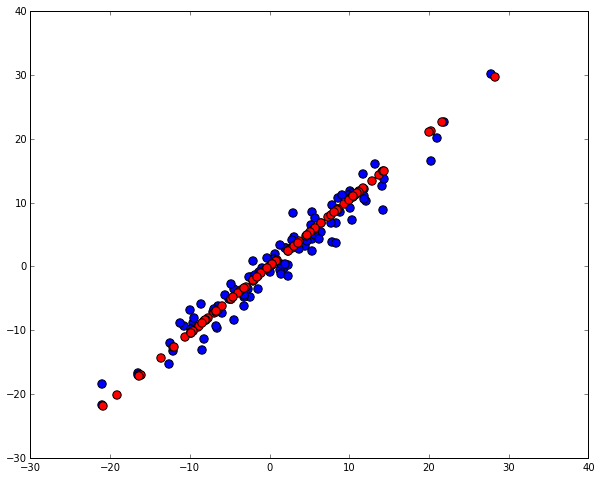

In [12]:
W = np.array([[10, 10]]).T
X, W, T = random_model(100, 2, 1, W=W, eps=2)

Xt = deepcopy(X) # original data

add_missing(X, .2) # deletes 20% of points
empcam = EMPCAM(n_components=1, n_iter=100)
empcam.fit(X)

Xf = empcam.fill_missing(X)

plt.figure(figsize=(10, 8))
plt.scatter(Xt[:, 0], Xt[:, 1], c='b', cmap='summer', s=70)
plt.scatter(Xf[:, 0], Xf[:, 1], c='r', cmap='summer', s=70)
plt.show()


